# Analysis of Changes in Biodiveristy Intactness Index (BII) in the Phoenix Metro Area

Author: Rachel Swick

Date: December 5, 2024

Github Link: https://github.com/rfswick/bii-changes-maricopa-county.git

## Purpose

To understand changes in BII in Maricopa County, which contains the Phoenix metro area, by creating visualizations showing BII in Maricopa County.

## Highlights

- 
- 
- 

## About the Data

## References


## Import Libraries

In [28]:
# Load libraries
import contextily as cx
import numpy as np
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import rioxarray as rioxr
from pystac_client import Client
import planetary_computer
from IPython.display import Image

## Load Data

### Biodiversity Intactness Index (BII) Time Series Data



In [2]:
# Load BII data for 2017 and 2020
# Access MPC catalog
catalog = Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
)

# Maricopa county bounding box
bbox = {
        "type": "Polygon",
        "coordinates":[
        [
            [-112.826843, 32.974108],  # lower left corner (longitude, latitude)
            [-111.184387, 32.974108],  # lower right corner
            [-111.184387, 33.863574],  # upper right corner
            [-112.826843, 33.863574],  # upper left corner
            [-112.826843, 32.974108]   # closing the polygon (same as start point)
        ]
    ],
}

# Search catalog and retrieve search items
items = catalog.search(
        collections = ['io-biodiversity'],
        intersects = bbox).item_collection()

# Four items in the catalog match the search
# Determine which items in the list contain 2017 and 2020 bii data
list(items)

[<Item id=bii_2020_34.74464974521749_-115.38597824385106_cog>,
 <Item id=bii_2019_34.74464974521749_-115.38597824385106_cog>,
 <Item id=bii_2018_34.74464974521749_-115.38597824385106_cog>,
 <Item id=bii_2017_34.74464974521749_-115.38597824385106_cog>]

In [3]:
# Select the 2017 and 2020 items in the catalog search
year_17 = items[3]
year_20 = items[0]

# Print `year_17` ID and assets
print('ID:' , year_17.id, '\n')
for key in year_17.assets.keys():
    print(key, '--', year_17.assets[key].title)

# Print `year_20` ID and assets
print('\nID:' , year_20.id, '\n')
for key in year_20.assets.keys():
    print(key, '--', year_20.assets[key].title)

ID: bii_2017_34.74464974521749_-115.38597824385106_cog 

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview

ID: bii_2020_34.74464974521749_-115.38597824385106_cog 

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [4]:
# Load 2017 and 2020 BII data
bii_17 = rioxr.open_rasterio(year_17.assets['data'].href)
bii_20 = rioxr.open_rasterio(year_20.assets['data'].href)

### Phoenix Subdivision Shapefile

In [5]:
# Load Arizona county subdivisions
arizona_subdivisions = gpd.read_file(os.path.join('data', 'tl_2022_04_cousub', 'tl_2022_04_cousub.shp'))

# Filter to Phoenix subdivision
phoenix_subdivision = arizona_subdivisions[arizona_subdivisions['NAME'] == 'Phoenix']

## Data Exploration

### BII Data Exploration

In [6]:
# Basic description of `io-biodiversity` collection
catalog.get_child('io-biodiversity')

<CollectionClient id=io-biodiversity>

### 2017 BII Data Exploration

In [11]:
# Display `bii_17` contents
bii_17

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [7]:
# Display the shape, data type, and dimensions of the underlying array
print('Shape: ', bii_17.shape)
print('Data type: ', bii_17.dtype)
print("Dimensions:", bii_17.dims)

Shape:  (1, 7992, 7992)
Data type:  float32 



In [14]:
# Display the coordinates in `bii_20`
bii_17.coords

Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0

### 2020 BII Data Exploration

In [12]:
# Display `bii_20` contents
bii_20

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
array([[[0.944002, 0.944016, ..., 0.928385, 0.928341],
        [0.944072, 0.944086, ..., 0.928497, 0.928456],
        ...,
        [0.744465, 0.744465, ..., 0.922526, 0.853522],
        [0.744465, 0.744465, ..., 0.942745, 0.922538]]], dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [20]:
# Display the shape, data type, and dimensions of the underlying array
print('Shape: ', bii_20.shape)
print('Data type: ', bii_20.dtype)
print("Dimensions:", bii_20.dims)

Shape:  (1, 7992, 7992)
Data type:  float32
Dimensions: ('band', 'y', 'x')


In [13]:
# Display the coordinates in `bii_20`
bii_20.coords

Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0

### Phoenix Subdivision Data

In [21]:
# Display first 5 rows of `phoenix_subdivision`
phoenix_subdivision.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
10,04,013,92601,01934968,0401392601,Phoenix,Phoenix CCD,22,Z5,G4040,None,None,None,S,2806478817,9471127,+33.5211331,-112.0284405,"POLYGON ((-112.47014 33.55996, -112.47011 33.5..."


In [22]:
# Determine the data types of the columns
phoenix_subdivision.dtypes

STATEFP       object
COUNTYFP      object
COUSUBFP      object
COUSUBNS      object
GEOID         object
NAME          object
NAMELSAD      object
LSAD          object
CLASSFP       object
MTFCC         object
CNECTAFP      object
NECTAFP       object
NCTADVFP      object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object

### Data Exploration Summary


## Cleaning

Each year of biodiversity intactness index (IDD) data contains an extra band making the data 3-dimensional when that is not necessary. Remove the band to make the data 2-dimensional and easier to work with.

In [24]:
# Original dimensions and coordinates
print(bii_17.dims, bii_17.coords, '\n')
print(bii_20.dims, bii_20.coords)

('band', 'y', 'x') Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0 

('band', 'y', 'x') Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0


In [25]:
# Remove band dimension
# Remove coordinates associated to band
bii_17 = bii_17.squeeze()
bii_17 = bii_17.drop_vars('band')
print(bii_17.dims, bii_17.coords)

('y', 'x') Coordinates:
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0


In [26]:
# Remove band dimension
# Remove coordinates associated to band
bii_20 = bii_20.squeeze()
bii_20 = bii_20.drop_vars('band')
print(bii_20.dims, bii_20.coords)

('y', 'x') Coordinates:
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0


## Map of the Phoenix Subdivision

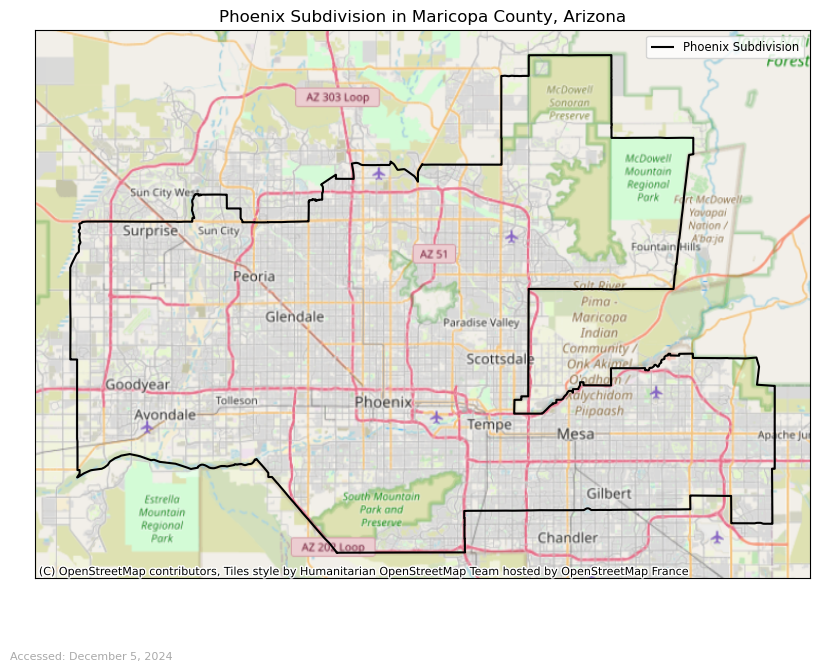

In [32]:
# Plot
fig, ax = plt.subplots(figsize=(10, 8))  

# Add phoenix subdivision data
phoenix_subdivision.geometry.boundary.plot(ax=ax,
                                           color='black',
                                           linewidth=1.5,
                                           label="Phoenix Subdivision")

# Add geographic context
cx.add_basemap(ax, crs=phoenix_subdivision.crs)

# Add legend
ax.legend(fontsize='small')

# Add title
ax.set_title("Phoenix Subdivision in Maricopa County, Arizona")  

# Remove axes ticks
ax.set_xticks([])  
ax.set_yticks([])  

# Remove axes labels
ax.set_xlabel("")  
ax.set_ylabel("") 

# Add credits
plt.figtext(0.1, 0.05, 
            "Accessed: December 5, 2024", 
            fontsize=8, 
            color="darkgrey")

plt.show()